<a href="https://www.kaggle.com/code/christopherbartos/tickerpricepredictionyoy?scriptVersionId=132694768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Ticker Price Predictions

The code implements a neural network model, PricePredictor, trained on historical stock price data to predict future stock prices, visualizing the predictions alongside historical prices and calculating the average of the predicted prices.

This is by no means meant to provide financial advice, this was done for self learning purposes and I am not responsible for any lincurred losses.

Training loss is around 300

# Installation

Before running the code you need to install the required dependency.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00


# Importing Libraries

Import the required libraries for data handling, model creation, optimization and visualization.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Device Configuration

Set the device to be used for training. It checks if CUDA is available and uses the GPU; otherwise, it falls back to using the CPU, change this if using more than a single gpu later:

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Retrieval

Fetch the historical data for a specific stock (e.g., Intel - "INTC") using the Yahoo Finance library:

Change the ticker parameter to whatever ticker you want:

In [4]:
ticker = "INTC"
ticker_val = yf.Ticker(ticker)
df = ticker_val.history(period="max")

# Data Preparation

Filter the historical data to include only the current year's data:

In [5]:
current_year = pd.Timestamp.now().year
df = df[df.index.year == current_year]

Calculate the average price based on all the historical data (change to another average if not wanting to use the mean):

In [6]:
average_price = df['Close'].mean()

Create a new dataframe with the days and prices related to those days:

In [7]:
data = pd.DataFrame({'Days': range(1, len(df) + 1), 'Prices': df['Close'].values})

Convert the data to pytorch tensors since I am using pytorch for this project:

In [8]:
X_train = torch.tensor(data['Days'].values.reshape(-1, 1), dtype=torch.float32).to(device)
y_train = torch.tensor(data['Prices'].values.reshape(-1, 1), dtype=torch.float32).to(device)

# Dataset and Dataloader

Create a pytorch dataset and dataloader for training

In [9]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Model Architecture
Define the architecture of the neural network model (PricePredictor) using the nn.Module class:

In [10]:
class PricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x):
        x = self.leakyrelu(self.fc1(x))
        x = self.leakyrelu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model Training

Initialize the model and optimizer, start the training loop:

In [11]:
model = PricePredictor(input_size=1, hidden_size=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Train the model
train_losses = []
best_loss = float('inf')
patience = 0

for epoch in range(100):
    model.train()
    train_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch+1, train_loss))
    scheduler.step(train_loss)
    
    if train_loss < best_loss:
        best_loss = train_loss
        patience = 0
    else:
        patience += 1
        # I have it set to 5 so if the train loss doesn't improve we'll use the last value here.
        if patience >= 5:
            print('Early stopping')
            break

Epoch: 1, Training Loss: 702.3019
Epoch: 2, Training Loss: 476.8992
Epoch: 3, Training Loss: 316.9273
Epoch: 4, Training Loss: 219.9361
Epoch: 5, Training Loss: 187.6064
Epoch: 6, Training Loss: 208.1275
Epoch: 7, Training Loss: 246.3920
Epoch: 8, Training Loss: 270.1980
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 9, Training Loss: 272.3238
Epoch: 10, Training Loss: 270.8103
Early stopping


# Price Prediction

*Change future_days to **x** where **x** is the number of days you want to predict.*

Use the trained model to predict prices for future days whilst using a random noise to apply noise to determine the values ranges to plot:

In [12]:
future_days = 30
predictions = []

# Calculate the historical prices based on the model and previous values
historical_prices = data['Prices'].values.tolist()

# List to store the predicted prices
predicted_prices = []

with torch.no_grad():
    for _ in range(future_days):
        last_day = data['Days'].iloc[-1]
        next_day = last_day + 1

        # Calculate the predicted price based on the historical average and the previous value
        predicted_price = (historical_prices[-1] + average_price) / 2

        # Add random noise to the predicted price based on historical average and previous value
        noise = np.random.normal(0, average_price / 10) 
        predicted_price += noise

        # Append the predicted price to the list
        historical_prices.append(predicted_price)
        predicted_prices.append(predicted_price)

        # Update the input with the predicted price for the next iteration
        data = pd.DataFrame({'Days': range(1, len(historical_prices) + 1), 'Prices': historical_prices})
        X_train = torch.tensor(data['Days'].values.reshape(-1, 1), dtype=torch.float32).to(device)
        y_train = torch.tensor(data['Prices'].values.reshape(-1, 1), dtype=torch.float32).to(device)
        train_dataset = TensorDataset(X_train, y_train)
        train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Calculate the average of the predicted prices
average_predicted_price = np.mean(predicted_prices)

# Visualization

Plot the predicted prices as dots, which we'll later average out next to determine a line for a continuation in the historical prices.

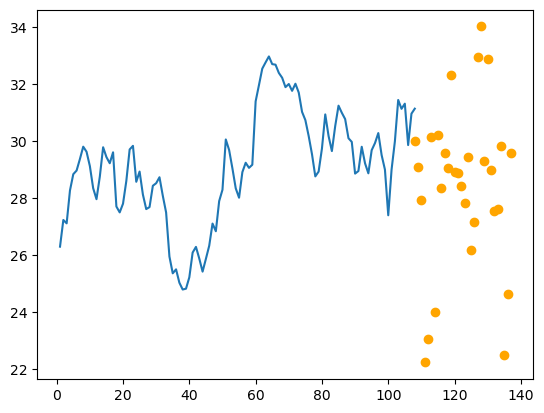

In [13]:
# Plot the historical prices as a line
plt.plot(data['Days'][:-future_days], data['Prices'][:-future_days], label='Historical Prices')

# Plot the predicted prices as dots
plt.scatter(range(last_day - future_days + 1, last_day + 1), predicted_prices, label='Predicted Prices', marker='o', color='orange')

# Calculate the average line
average_line = np.array(predicted_prices)

# Calculate the average distance between the predicted points
distances = np.diff(predicted_prices)
average_distance = np.mean(np.abs(distances))

# Calculate the window size for the moving average
window_size = int(np.ceil(average_distance))

# Calculate the moving average of the predicted prices
average_line = np.convolve(average_line, np.ones(window_size)/window_size, mode='valid')

# Calculate the range of days to plot the average line
start_day = last_day - future_days + 1 + window_size//2
end_day = start_day + len(average_line) - 1

# Plot the lines using matplotlib

Displays the average line of the plotted points

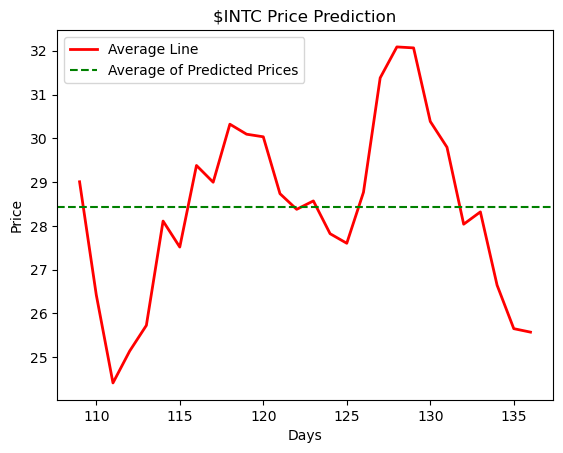

In [14]:
# Plot the average line
plt.plot(range(start_day, end_day + 1), average_line, 'r', linewidth=2, label='Average Line')# Plot the average of the predicted prices as a green dashed line
plt.axhline(y=average_predicted_price, color='g', linestyle='--', label='Average of Predicted Prices')

plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f'${ticker} Price Prediction')
plt.legend()
plt.show()

# Full graph with the price predictions together

Displays the price predictions amongst the historical averages.

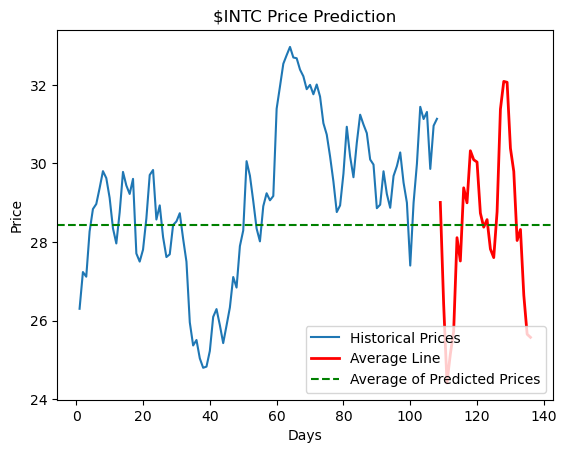

In [15]:
# Plot the historical prices as a line
plt.plot(data['Days'][:-future_days], data['Prices'][:-future_days], label='Historical Prices')

# Calculate the average line
average_line = np.array(predicted_prices)

# Calculate the average distance between the predicted points
distances = np.diff(predicted_prices)
average_distance = np.mean(np.abs(distances))

# Calculate the window size for the moving average
window_size = int(np.ceil(average_distance))

# Calculate the moving average of the predicted prices
average_line = np.convolve(average_line, np.ones(window_size)/window_size, mode='valid')

# Calculate the range of days to plot the average line
start_day = last_day - future_days + 1 + window_size//2
end_day = start_day + len(average_line) - 1

# Plot the average line
plt.plot(range(start_day, end_day + 1), average_line, 'r', linewidth=2, label='Average Line')# Plot the average of the predicted prices as a green dashed line
plt.axhline(y=average_predicted_price, color='g', linestyle='--', label='Average of Predicted Prices')

plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f'${ticker} Price Prediction')
plt.legend()
plt.show()